# 0. Intro

### Dataset

Project Sentiment Analysis bertujuan untuk mengembangkan sistem cerdas berbasis teknologi AI untuk mengklasifikasi sentiment pada twitter dengan metode text analysis. Sistem ini akan membantu memperoleh **kecenderungan sentimen opini positif, negatif atau netral** dari pengguna di platform tersebut.

Dataset yang digunakan adalah kumpulan tweet dari pengguna twitter saat pelaksanaan **Pilpres 2019**. Dataset tersebut  didapat melalui proses web scraping. Data terdiri dari 1815 tweet yanng memuat tiga kategori sentimen: positif, netral, dan negatif.

### Alur Pelaksanaan

Eksperimen dilakukan dengan menggunakan berbagai ragam teknik preprocessing dan vectorization. Selain itu juga menggunakan **menguji algoritma Random Forest dan LSTM (ditambah hyperparameter tuning untuk model optimization)**.

Setelah itu dilakukan model evaluation dan penarikan kesimpulan untuk memilih algoritma terbaik.

Setelah project selesai, hasil pengerjaan dapat dipublikasikan ke Github.

### Timeline

- 1-7 Juli: Data & Algoritma understanding
- 8-9 Juli: Group Discussion
- 10-14 Juli: Model training & Evaluation
- 15 Juli: Presentation Preparation
- 16 Juli: Project Presentation

# 1. Data Loading

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth',None)

In [2]:
tweets = pd.read_csv('/content/tweet.csv', index_col=0)

# 2. EDA (before text cleaning)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

In [4]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1815 entries, 0 to 1814
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentimen  1815 non-null   object
 1   tweet     1815 non-null   object
dtypes: object(2)
memory usage: 42.5+ KB


In [5]:
tweets.shape

(1815, 2)

In [6]:
tweets.isnull().sum()

sentimen    0
tweet       0
dtype: int64

In [7]:
tweets.head()

,sentimen,tweet
0,negatif,"Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â â€¦"
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy? http://dlvr.it/R2pvZVÂ"
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat pic.twitter.com/W2ythnxsTp"
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!"
4,negatif,"Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh karena negara ngutang, setiap negara itu pasti ngutang, utang bisa dibayar kalo negara dapet penghasilan. Penghasilan negara itu ya dari pajak"


## 2.1. Distribution of Sentiment

In [8]:
tweets.sentimen.value_counts()

positif    612
netral     607
negatif    596
Name: sentimen, dtype: int64

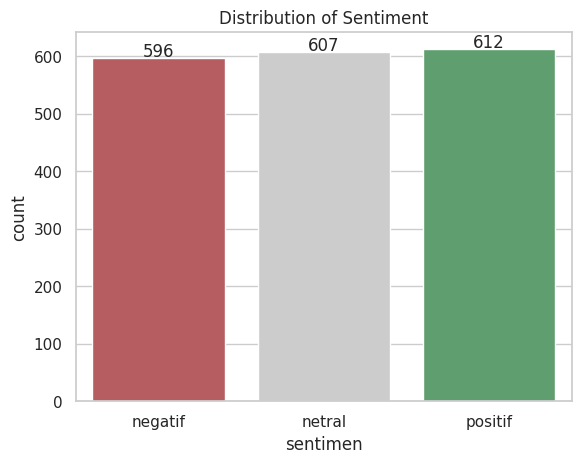

In [9]:
color_palette = {'negatif': 'r', 'netral': '#CCCCCC', 'positif': 'g'}

ax = sns.countplot(data=tweets, x='sentimen', palette=color_palette)
for p in ax.patches:
    ax.annotate(format(p.get_height(),'.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Sentiment')
plt.show()

## 2.2. Number word string

In [10]:
tweets['num_words'] = tweets['tweet'].apply(lambda x:len(str(x).split()))

tweets_negatif = tweets[tweets['sentimen']=='negatif']
tweets_netral = tweets[tweets['sentimen']=='netral']
tweets_positif = tweets[tweets['sentimen']=='positif']

### 2.2.1. All Sentiment

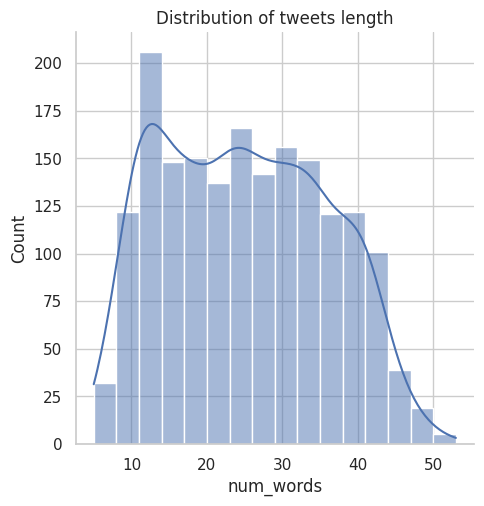

In [11]:
sns.displot(tweets['num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

### 2.2.2. negatif sentiment

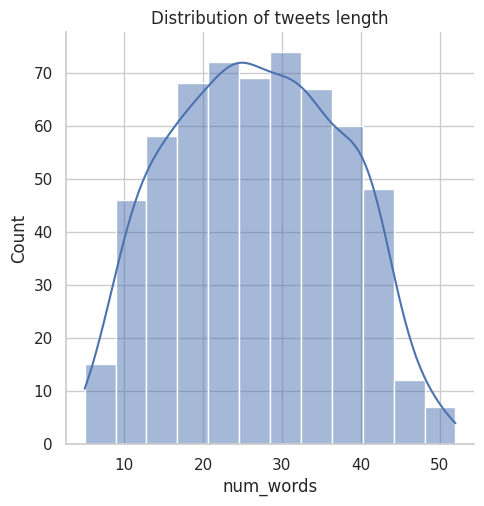

In [12]:
sns.displot(tweets_negatif['num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

### 2.2.3. netral sentiment

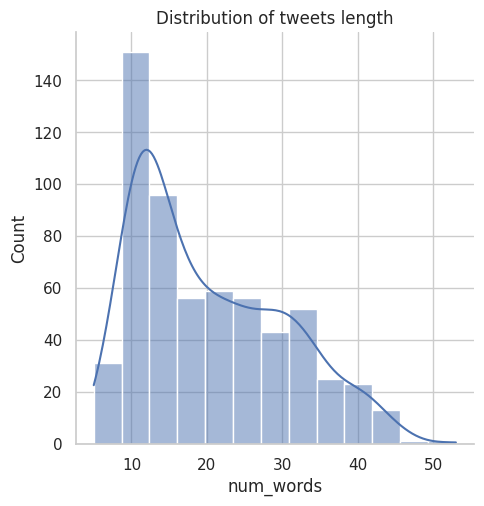

In [13]:
sns.displot(tweets_netral['num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

### 2.2.4. positif sentiment

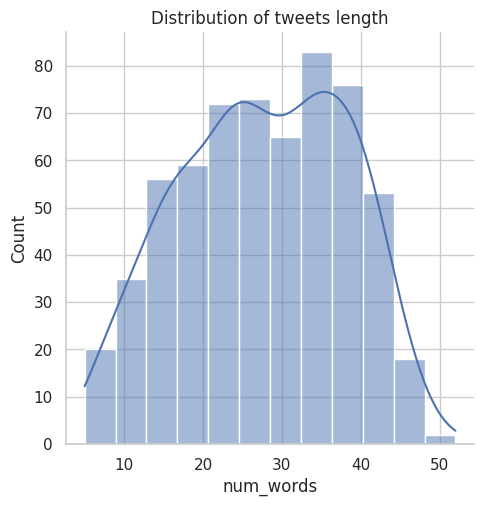

In [14]:
sns.displot(tweets_positif['num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

# 3. Text Preprocessing

0. Remove url and punctuation
1. Slang words to standard words conversion
2. Tokenization
3. Stemming & Lemmatization
4. Stop words removal
5. Word embedding

In [15]:
!pip install sastrawi

In [16]:
import re
import string

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

### create list stopword

perlu tambahkan beberapa stopword

ga, gak, yg, pak, akan, utk, di, untuk, itu

wowo --> prabowo

In [17]:
class ExtendStopWordRemoverFactory(StopWordRemoverFactory):
    def get_stop_words(self):

        add_sw = ['ga', 'gak', 'yg', 'pak','bapak','ibu','bu','akan', 'utk', 'di', 'untuk', 'itu','selain itu'
                 ,"ud","udah","sdh","sudah","kalau","klo","sy","aing","saia","gue","awak","aq","gua","gw","ak","aku","saya","banget","blibli","tokopedia","shopee","bukalapak","lazada","jdid","zalora","elevenia","sudah","bhinneka","gk","yg","ga","gak","nggak","saja","aja","aj","ada","adalah","adanya","adapun","agak","agaknya","agar","akan","akankah","akhir","akhiri","akhirnya","aku","akulah","amat","amatlah","anda","andalah","antar","antara","antaranya","apa","apaan","apabila","apakah","apalagi","apatah","artinya","asal","asalkan","atas","atau","ataukah","ataupun","awal","awalnya","bagai","bagaikan","bagaimana","bagaimanakah","bagaimanapun","bagi","bagian","bahkan","bahwa","bahwasanya","baik","bakal","bakalan","balik","banyak","bapak","baru","bawah","beberapa","begini","beginian","beginikah","beginilah","begitu","begitukah","begitulah","begitupun","bekerja","belakang","belakangan","belum","belumlah","benar","benarkah","benarlah","berada","berakhir","berakhirlah","berakhirnya","berapa","berapakah","berapalah","berapapun","berarti","berawal","berbagai"
                ,"berdatangan","beri","berikan","berikut","berikutnya","berjumlah","berkali-kali","berkata","berkehendak","berkeinginan","berkenaan","berlainan","berlalu","berlangsung","berlebihan","bermacam","bermacam-macam","bermaksud","bermula","bersama","bersama-sama","bersiap","bersiap-siap","bertanya","bertanya-tanya","berturut","berturut-turut","bertutur","berujar","berupa","besar","betul","betulkah","biasa","biasanya","bila","bilakah","bisa","bisakah","boleh","bolehkah","bolehlah","buat","bukan","bukankah","bukanlah","bukannya","bulan","bung","cara","caranya","cukup","cukupkah","cukuplah","cuma","dahulu","dalam","dan","dapat","dari","daripada","datang","dekat","demi","demikian","demikianlah","dengan","depan","di","dia","diakhiri","diakhirinya","dialah","diantara","diantaranya","diberi","diberikan","diberikannya","dibuat","dibuatnya","didapat","didatangkan","digunakan","diibaratkan","diibaratkannya","diingat","diingatkan","diinginkan","dijawab","dijelaskan","dijelaskannya","dikarenakan","dikatakan","dikatakannya","dikerjakan","diketahui"
            ,"diketahuinya","dikira","dilakukan","dilalui","dilihat","dimaksud","dimaksudkan","dimaksudkannya","dimaksudnya","diminta","dimintai","dimisalkan","dimulai","dimulailah","dimulainya","dimungkinkan","dini","dipastikan","diperbuat","diperbuatnya","dipergunakan","diperkirakan","diperlihatkan","diperlukan","diperlukannya","dipersoalkan","dipertanyakan","dipunyai","diri","dirinya","disampaikan","disebut","disebutkan","disebutkannya","disini","disinilah","ditambahkan","ditandaskan","ditanya","ditanyai","ditanyakan","ditegaskan","ditujukan","ditunjuk","ditunjuki","ditunjukkan","ditunjukkannya","ditunjuknya","dituturkan","dituturkannya","diucapkan","diucapkannya","diungkapkan","dong","dua","dulu","empat","enggak","enggaknya","entah","entahlah","guna","gunakan","hal","hampir","hanya","hanyalah","hari","harus","haruslah","harusnya","hendak","hendaklah","hendaknya","hingga","ia","ialah","ibarat","ibaratkan","ibaratnya","ibu","ikut","ingat","ingat-ingat","ingin","inginkah","inginkan","ini","inikah","inilah","itu","itukah","itulah","jadi","jadilah"
            ,"jadinya","jangan","jangankan","janganlah","jauh","jawab","jawaban","jawabnya","jelas","jelaskan","jelaslah","jelasnya","jika","jikalau","juga","jumlah","jumlahnya","justru","kala","kalau","kalaulah","kalaupun","kalian","kami","kamilah","kamu","kamulah","kan","kapan","kapankah","kapanpun","karena","karenanya","kasus","kata","katakan","katakanlah","katanya","ke","keadaan","kebetulan","kecil","kedua","keduanya","keinginan","kelamaan","kelihatan","kelihatannya","kelima","keluar","kembali","kemudian","kemungkinan","kemungkinannya","kenapa","kepada","kepadanya","kesampaian","keseluruhan","keseluruhannya","keterlaluan","ketika","khususnya","kini","kinilah","kira","kira-kira","kiranya","kita","kitalah","kok","kurang","lagi","lagian","lah","lain","lainnya","lalu","lama","lamanya","lanjut","lanjutnya","lebih","lewat","lima","luar","macam","maka","makanya","makin","malah","malahan","mampu","mampukah","mana","manakala","manalagi","masa","masalah","masalahnya","masih","masihkah","masing","masing-masing","mau","maupun","melainkan","melakukan","melalui"
            ,"melihat","melihatnya","memang","memastikan","memberi","memberikan","membuat","memerlukan","memihak","meminta","memintakan","memisalkan","memperbuat","mempergunakan","memperkirakan","memperlihatkan","mempersiapkan","mempersoalkan","mempertanyakan","mempunyai","memulai","memungkinkan","menaiki","menambahkan","menandaskan","menanti","menanti-nanti","menantikan","menanya","menanyai","menanyakan","mendapat","mendapatkan","mendatang","mendatangi","mendatangkan","menegaskan","mengakhiri","mengapa","mengatakan","mengatakannya","mengenai","mengerjakan","mengetahui","menggunakan","menghendaki","mengibaratkan","mengibaratkannya","mengingat","mengingatkan","menginginkan","mengira","mengucapkan","mengucapkannya","mengungkapkan","menjadi","menjawab","menjelaskan","menuju","menunjuk","menunjuki","menunjukkan","menunjuknya","menurut","menuturkan","menyampaikan","menyangkut","menyatakan","menyebutkan","menyeluruh","menyiapkan","merasa","mereka","merekalah","merupakan","meski","meskipun","meyakini","meyakinkan","minta","mirip","misal","misalkan","misalnya","mula","mulai","mulailah","mulanya","mungkin","mungkinkah","nah","naik","namun","nanti","nantinya","nyaris","nyatanya","oleh","olehnya","pada","padahal","padanya","pak","paling","panjang","pantas","para","pasti","pastilah","penting","pentingnya","per","percuma","perlu","perlukah","perlunya","pernah","persoalan","pertama","pertama-tama","pertanyaan","pertanyakan","pihak","pihaknya","pukul","pula","pun","punya","rasa","rasanya","rata","rupanya","saat","saatnya","saja","sajalah","saling","sama","sama-sama","sambil","sampai","sampai-sampai","sampaikan","sana","sangat","sangatlah","satu","saya","sayalah","se","sebab","sebabnya","sebagai","sebagaimana","sebagainya","sebagian","sebaik","sebaik-baiknya","sebaiknya","sebaliknya","sebanyak","sebegini","sebegitu","sebelum","sebelumnya","sebenarnya","seberapa","sebesar","sebetulnya","sebisanya","sebuah","sebut","sebutlah","sebutnya","secara","secukupnya","sedang","sedangkan","sedemikian","sedikit","sedikitnya","seenaknya","segala","segalanya","segera","seharusnya","sehingga","seingat","sejak","sejauh","sejenak","sejumlah","sekadar","sekadarnya","sekali","sekali-kali","sekalian","sekaligus","sekalipun","sekarang","sekarang","sekecil","seketika","sekiranya","sekitar","sekitarnya","sekurang-kurangnya","sekurangnya","sela","selain","selaku","selalu","selama","selama-lamanya","selamanya","selanjutnya","seluruh","seluruhnya","semacam","semakin","semampu","semampunya","semasa","semasih","semata","semata-mata","semaunya","sementara","semisal","semisalnya","sempat","semua","semuanya","semula","sendiri","sendirian","sendirinya","seolah","seolah-olah","seorang","sepanjang","sepantasnya","sepantasnyalah","seperlunya","seperti","sepertinya","sepihak","sering","seringnya","serta","serupa","sesaat","sesama","sesampai","sesegera","sesekali","seseorang","sesuatu","sesuatunya","sesudah","sesudahnya","setelah","setempat","setengah","seterusnya","setiap","setiba","setibanya","setidak-tidaknya","setidaknya","setinggi","seusai","sewaktu","siap","siapa","siapakah","siapapun","sini","sinilah","soal","soalnya","suatu","sudah","sudahkah","sudahlah","supaya","tadi","tadinya","tahu","tahun","tak","tambah","tambahnya","tampak","tampaknya","tandas","tandasnya","tanpa","tanya","tanyakan","tanyanya","tapi","tegas","tegasnya","telah","tempat","tengah","tentang","tentu","tentulah","tentunya","tepat","terakhir","terasa","terbanyak","terdahulu","terdapat","terdiri","terhadap","terhadapnya","teringat","teringat-ingat","terjadi","terjadilah","terjadinya","terkira","terlalu","terlebih","terlihat","termasuk","ternyata","tersampaikan","tersebut","tersebutlah","tertentu","tertuju","terus","terutama","tetap","tetapi","tiap","tiba","tiba-tiba","tidak","tidakkah","tidaklah","tiga","tinggi","toh","tunjuk","turut","tutur","tuturnya","ucap","ucapnya","ujar","ujarnya","umum","umumnya","ungkap","ungkapnya","untuk","usah","usai","waduh","wah","wahai","waktu","waktunya","walau","walaupun","wong","yaitu","yakin","yakni","yang","anjing","anjiang","anjir","anjay","anying","asu","asoe","babi","bajingan","banci","bangsat","bego","bengak","berak","bokong","bodoh","bongak","edan","fak","fuck","fakboi","bitch","fap","gigolo","goblok","gila","gilo","jablay","jalang","jancuk","jancok","kampret","kafir","kontol","kentot","dancok","kunyuk","kufar","kimak","homo","maho","memek","monyet","ngentot","pantat","pantak","pantek","pecun","pelakor","ngehe","pelacur","perek","peler","pepek","pukimak","setan","syaithon","saiton","sial","sialan","sinting","sintiang","silit","sontoloyo","tai","telek","tolol","lonte","entut","gimana","widihh","nya","gabisa","nambah","kontoll","ih","sih","selesai","banget","si","knapa","bngt","kamu","an","tanggal","dizalora","in","an","ini","emang","sngt","many","to","thank","you","ko","tumben","lho","segitu","kalau","doang","ayo","doank","rbuan","woi","parahhhh","trus","woy","emg","gausah","udh","gadak","huhh","akh","nanti","belum","cuiiihhh","bangt","selamat","begitu","bhineka","situ","loh","deh","mah","yaa","tapi","the","karena","padabal","ttep","sopi","ealah","mas","kampreeeeet","busetttt","tahi","ah","sich","tokped","lzd","gada","gatau","udh","ttep","ehhh","bosss","wkekwk","bajing","laknat","asuuu","ku","woiii","gueeee","njerr","waduhhhh","ma","dunk","dunk","untuk","dll","brupa","sangatx","niih","bos","eh","smua","gni","bye","ajah","gilee","luu","ndro","dg","kga","min","sm","haisshhh","piye","iki","skali","hehehe","ms","juga","fff","mamam","inibsangat","andri","yopiyanto","broo","donk","tes","si","ter","dech","wow","oh","toped","dahhhh","grab","ijo","oren","ovo","gopay","kredivo","sok","david","gaes","dr","ovonya","bbrp","gmna","bbrpa","and","uah","uhahhhhhh","topeeed","ngak","kamu","anj","nge","lah","linkaja","gosend","sicepat","jne","yah","goto","gofood","goride","prakerja","haduhhhh","pediya","kakak","hhe","bro","bismillah","fuulll","goof","assalamualaikum","atsu","pea","you","agan","semenjak","gojek","lagiii","lagi","bts","kkzara","cog","aaaaa","sich","cih","ciyy","padahal","ad","adlh","ahaha","aj","ak","akika","akkoh","akuwh","alow","anjrit","ap2","apasih","aps","aq","aqueh","q","asem","ato","awak","bakalan","bangedh","bcanda","beud","bg","bgmn","bgt","bkl","bknnya","blum","boljug","boyeh","bs","bt","btw","bwt","byk","can","thanks","d","dah","dapet","de","dek","deyh","dgn","disono","dkk","dlu","dngn","dongs","dpt","dri","drmn","drtd","dst","duh","egp","eke","ane","ente","elu","emangnya","emng","endak","enggak","gaada","gag","gaje","gpp","gan","gbs","geje","ghiy","gimana","githu","gj","gn","gt","gpny","gr","gtau","guoblok","ha","haha","hallow","hehe","helo","he","halo","hey","hai","hny","hrus","imho","iye","ja","jadiin","jdi","jga","jir","k","kagak","kalo","kamuwh","karna","katrok","kayanya","kdu","kepengen","kepingin","kl","klianz","klw","km","knp","kpn","kt","kyk","leh","lgi","lgsg","liat","low","lum","maneh","mao","mw","n","napa","nda","ne","ngapah","ngga","ngmng","nie","nih","niyh","np","ogah","pd","pi","pisan","qmu","ruz","saia","samsek","siech","sj","spt","sgt","shg","scr","sbh","sbnrny","sdgkn","td","thankz","tks","ttg","tuch","tuh","u","urang","yawdah","yasudah","adlah","ajj","akko","akyu","ama","aqu","atuh","ayok","bet","beut","bgd","brur","bapak","ibu","bokap","nyokap","cama","ceu","teh","coz","cpa","guys","kaka","kamuh","kamyu","kau","khan","kk","klian","koq","ky","krn","kykny","lu","lw","maaciw","makasih","mba","mas","nyok","qmo","qt","spy","sy","thanks","thx","tp","tq","trims","mz","alfamart","cm","buruk","lambat","jelek","bagus","ok","oke","kecewa","mantap","manfaat","gblk","ni","keren","bagus","ajg","iya","tidak","muas","puas","goblog","tdk","dancuk","huff","lumayan","mayan","y","eek","belum","blm","nyesel","bahagia","senang","seneng","mantul","good","top","suka","not","bad","kak","okey","gitu","coba","sip","nice","job","thanks","terima kasih","moga","lasada","jd","id","parah","for","sumpah","best","bli","payah","blibi","blipay","gg","love","amazing","mantab","terimakasih","cakep","very","bgs","jos","is","euy","gandos","of","waw","biar","buka","lapak","terima","kasih","alhamdulillah","pokok","shoope","shoppe","shope","san"
                 ]

        with open('/content/20190327_stopword_id.txt') as sw:  # use the stopword list
            new_sw = sw.readlines()
            new_sw = [value.replace('\n', '').strip() for value in new_sw]

            new_sw = new_sw + add_sw              # add the additional stopwords

        new_sw.extend(super().get_stop_words())   # combine stopword from Sastrawi and custom stopwords
        return list(set(new_sw))                  # using set() to remove duplication values

In [18]:
# create sastrawi stopwords object
sw_remover = ExtendStopWordRemoverFactory().create_stop_word_remover()

### text cleaning and normalization

In [19]:
# text cleaning

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def clean_text(text, sw_remover):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()                                               # case folding
    text = re.sub('\[.*?\]', '', text)                                     # remove punctuation
    text = re.sub('<.*?>+', '', text)                                      # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)        # remove punctuation
    text = re.sub('https?://\S+|www\.\S+', '', text)                       # remove all url starts with http or https
    text = re.sub('\n', '', text)                                          # remove newline character
    text = re.sub('\w*\d\w*', '', text)                                    # remove any word with number character in the middle
    text = re.sub('[^0-9a-zA-Z ]*', '', text)                              # remove all non-alphanumerical characters

    # Define the words to be replaced in a dictionary
    words_to_replace = {
        "yg": "",
        "yang": "",
        "di": "",
        "jadi": "",
        "itu": "",
        "ini": ""
    }

    for word, replacement in words_to_replace.items():
        text = text.replace(word, replacement)


    text = re.sub('#\w+', '', text)                                        # remove all hashtags
    text = re.sub(r'\s\s+', ' ', text)                                     # remove all consecutive whitespaces into only single whitespace
    text = stemmer.stem(text)                                              # convert words into the stem form
    text = sw_remover.remove(text)                                         # remove stopwords
    return text

In [ ]:
# text cleaning
tweets['cleaned_tweet'] = tweets['tweet'].apply(lambda x: clean_text(x, sw_remover))

In [ ]:
# get hashtags
tweets['hashtags'] = tweets['tweet'].apply(lambda x: re.findall(r'#\w+', x.lower())) # Find all hashtags in the tweet

# 4. EDA (after text cleaning)

In [ ]:
tweets['clean_num_words'] = tweets['cleaned_tweet'].apply(lambda x:len(str(x).split()))

tweets_negatif = tweets[tweets['sentimen']=='negatif']
tweets_netral = tweets[tweets['sentimen']=='netral']
tweets_positif = tweets[tweets['sentimen']=='positif']

In [ ]:
tweets.head()

,sentimen,tweet,num_words,cleaned_tweet,hashtags,clean_num_words
0,negatif,"Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â â€¦",19,prabowo indonesia harga bangsa asing berita hoax kuasa kan rockerung,[],10
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy? http://dlvr.it/R2pvZVÂ",11,batu langka tasbih jokowi haah habib luthfi harga mercy,[],9
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat pic.twitter.com/W2ythnxsTp",11,era jokowi ekonomi indonesia baik jokowilagi jokowimenangtotaldebat,"[#01indonesiamaju, #jokowilagi, #jokowimenangtotaldebat]",7
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!",17,sumatera selatan asi games dampak ekonomi langsung preksi capai triliun indonesia maju jokowi hebat,[],14
4,negatif,"Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh karena negara ngutang, setiap negara itu pasti ngutang, utang bisa dibayar kalo negara dapet penghasilan. Penghasilan negara itu ya dari pajak",34,negara ngutang bngun infrastruktur pake masyarakat masyarakat ngeluh negara ngutang negara ngutang utang bayar negara hasil hasil negara dari pajak,[],20


In [ ]:
tweets

,sentimen,tweet,num_words,cleaned_tweet,hashtags,clean_num_words
0,negatif,"Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â â€¦",19,prabowo indonesia harga bangsa asing berita hoax kuasa kan rockerung,[],10
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy? http://dlvr.it/R2pvZVÂ",11,batu langka tasbih jokowi haah habib luthfi harga mercy,[],9
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat pic.twitter.com/W2ythnxsTp",11,era jokowi ekonomi indonesia baik jokowilagi jokowimenangtotaldebat,"[#01indonesiamaju, #jokowilagi, #jokowimenangtotaldebat]",7
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!",17,sumatera selatan asi games dampak ekonomi langsung preksi capai triliun indonesia maju jokowi hebat,[],14
4,negatif,"Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh karena negara ngutang, setiap negara itu pasti ngutang, utang bisa dibayar kalo negara dapet penghasilan. Penghasilan negara itu ya dari pajak",34,negara ngutang bngun infrastruktur pake masyarakat masyarakat ngeluh negara ngutang negara ngutang utang bayar negara hasil hasil negara dari pajak,[],20
...,...,...,...,...,...,...
1810,netral,Negarawan sejati sll bangga dan mengedepankan harga diri bangsanya yg berdaulat #2019GantiPresiden,12,negarawan sejati sll bangga depan harga bangsa daulat,[#2019gantipresiden],8
1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekonomian makin membaik. #PutihkanGBK,11,hrs ceramah damai indonesia ekonomi baik putihkangbk,[#putihkangbk],7
1812,netral,Mari bangun bangsa dgn mendukung perekonomian negara bersama Pak Jokowi. Ayo kerja! https://twitter.com/KaskusLoker/status/1111643312241295363Â â€¦,14,bangun bangsa dukung ekonomi negara pak jokowi kerja,[],8
1813,netral,"Bantu majukan perekonomian bangsa bersama Pak Jokowi, yuk! https://twitter.com/BKNSquare/status/1113655944955588610Â â€¦",10,bantu maju ekonomi bangsa pak jokowi yuk,[],7


In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1815 entries, 0 to 1814
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentimen         1815 non-null   object
 1   tweet            1815 non-null   object
 2   num_words        1815 non-null   int64 
 3   cleaned_tweet    1815 non-null   object
 4   hashtags         1815 non-null   object
 5   clean_num_words  1815 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 99.3+ KB


## 4.1. Distribution of tweets length
### 4.1.1. All Sentiment

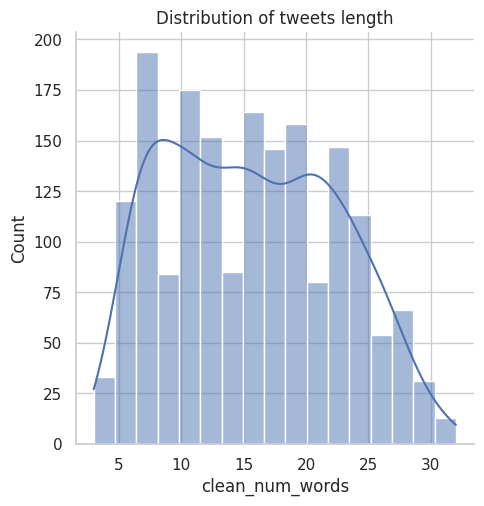

In [ ]:
sns.displot(tweets['clean_num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

### 4.1.2. Negatif Data

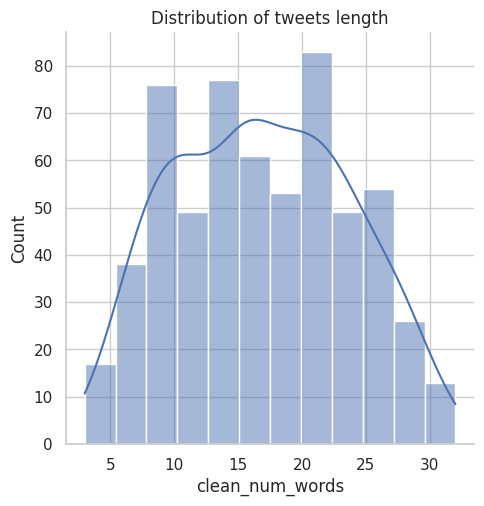

In [ ]:
sns.displot(tweets_negatif['clean_num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

### 4.1.3. Netral Data

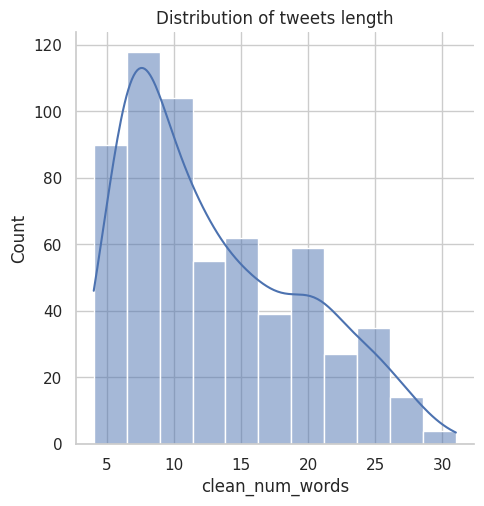

In [ ]:
sns.displot(tweets_netral['clean_num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

### 4.1.4. Positif Data

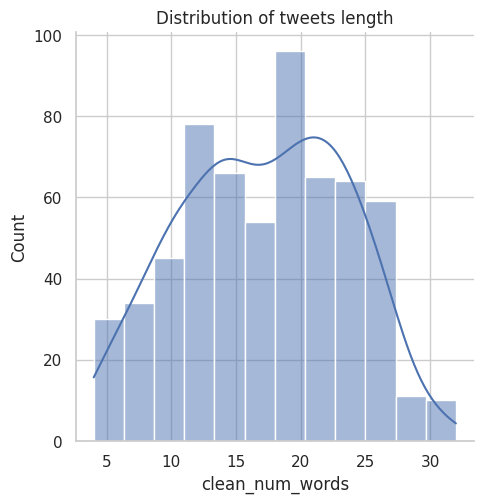

In [ ]:
sns.displot(tweets_positif['clean_num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

## 4.2. Text Tokenization

In [ ]:
from collections import Counter
from nltk.tokenize import RegexpTokenizer

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def count_top_n_words(tokenized_words, n):
    word_counts = Counter(tokenized_words)
    top_n_words = word_counts.most_common(n)
    return top_n_words

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

### 4.2.1. All  Sentiment

In [ ]:
text_tweet = tweets['cleaned_tweet'].values.tolist()
text_tweet = ' '.join(text_tweet).lower()
tokenized_text_tweet = tokenizer.tokenize(text_tweet)
word_counts = Counter(tokenized_text_tweet)

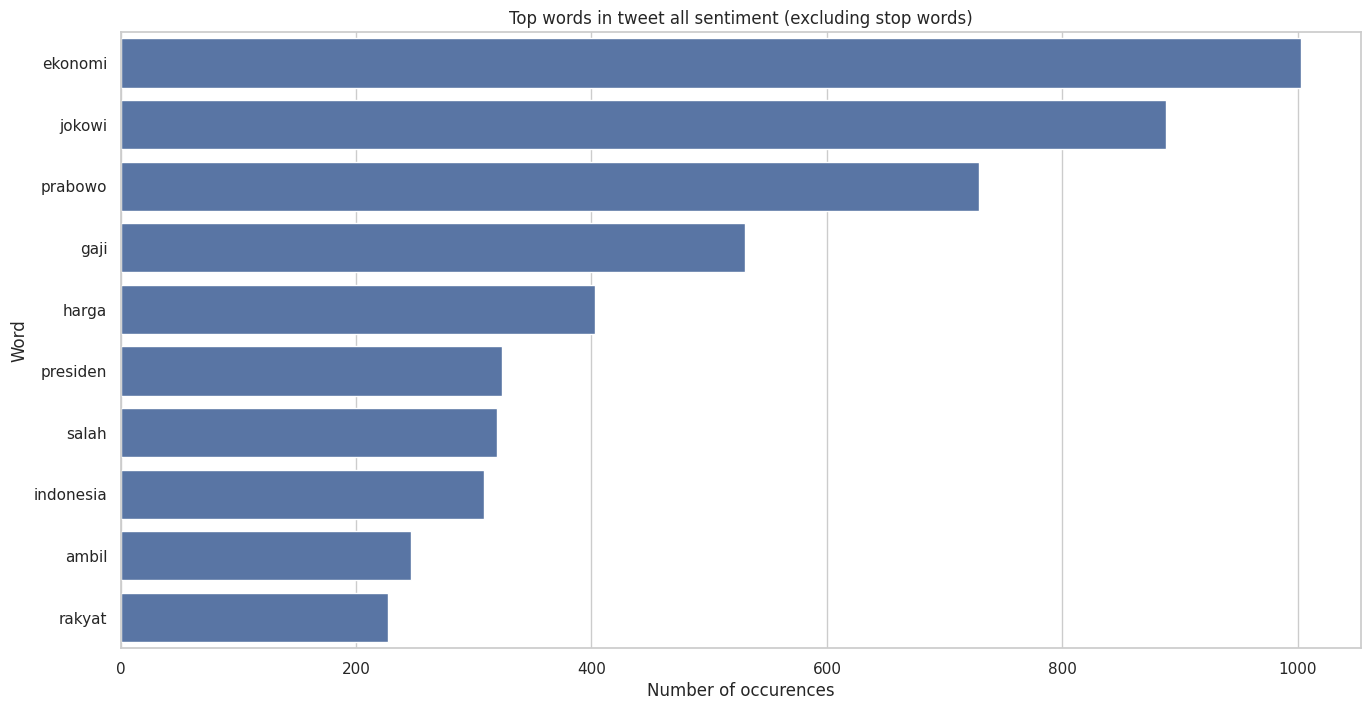

In [ ]:
# Top N words
top_n_words = count_top_n_words(tokenized_text_tweet, 10)  # get top 10 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words]
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= 'b');
ax.set_title('Top words in tweet all sentiment (excluding stop words)');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('Word');
plt.show()

### 4.2.2. Negatif Sentimen

In [ ]:
text_tweet = tweets_negatif['cleaned_tweet'].values.tolist()
text_tweet = ' '.join(text_tweet).lower()
tokenized_text_tweet = tokenizer.tokenize(text_tweet)
word_counts = Counter(tokenized_text_tweet)

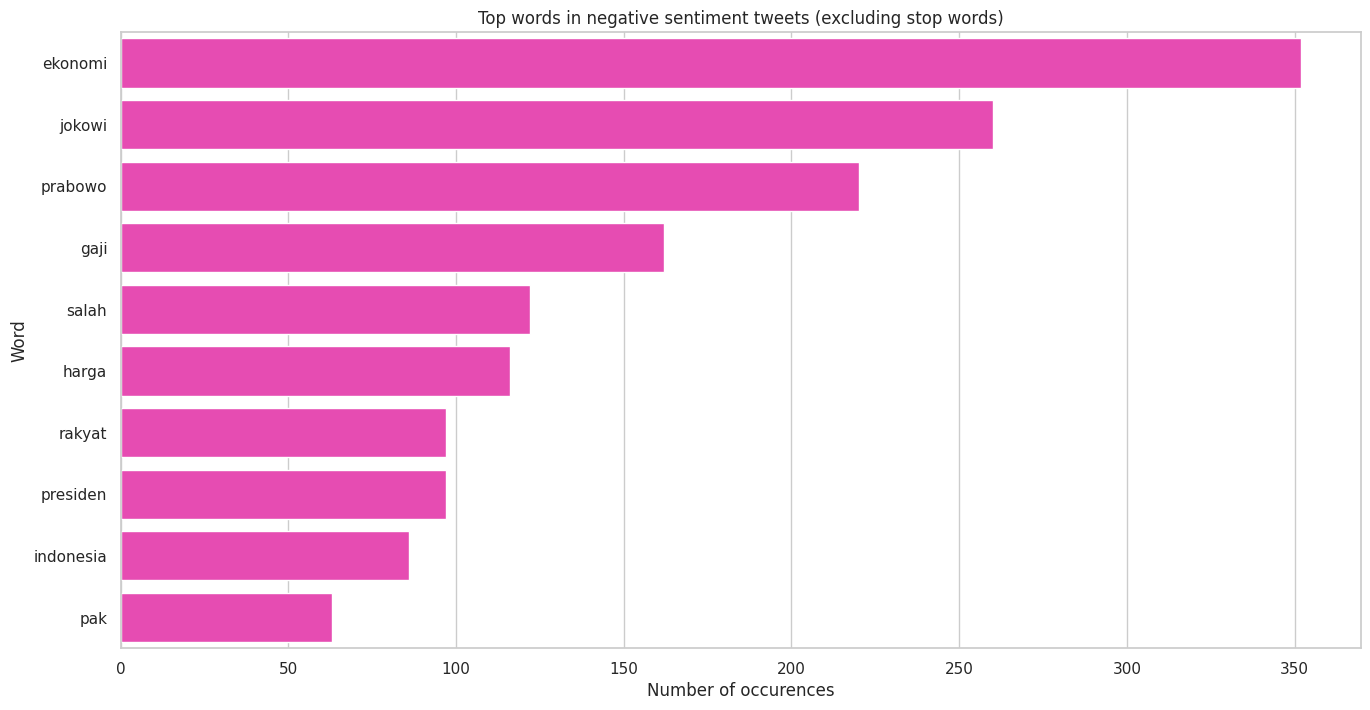

In [ ]:
# Top N words
top_n_words = count_top_n_words(tokenized_text_tweet, 10)  # get top 10 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words]
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#FF33BB');
ax.set_title('Top words in negative sentiment tweets (excluding stop words)');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('Word');
plt.show()

### 4.2.3. Netral Sentimen

In [ ]:
text_tweet = tweets_netral['cleaned_tweet'].values.tolist()
text_tweet = ' '.join(text_tweet).lower()
tokenized_text_tweet = tokenizer.tokenize(text_tweet)
word_counts = Counter(tokenized_text_tweet)

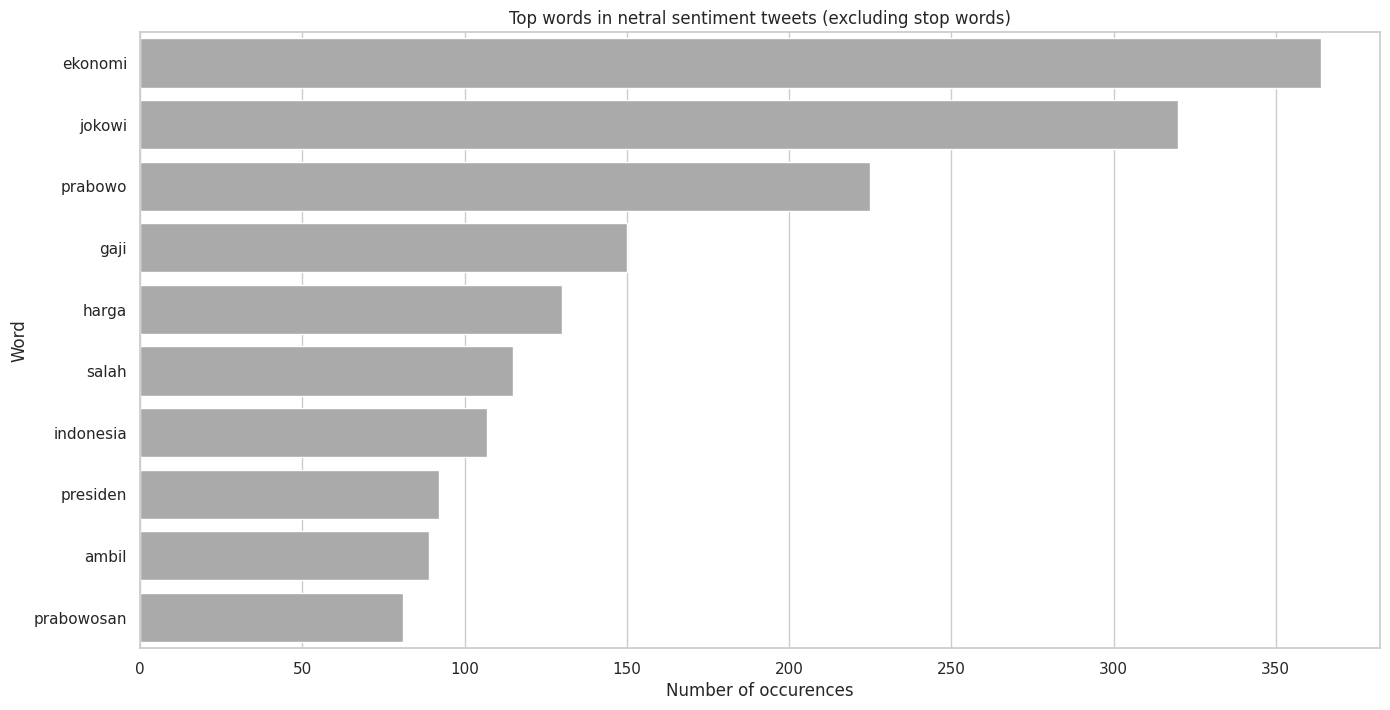

In [ ]:
# Top N words
top_n_words = count_top_n_words(tokenized_text_tweet, 10)  # get top 15 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words]
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#AAAAAA');
ax.set_title('Top words in netral sentiment tweets (excluding stop words)');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('Word');
plt.show()

### 4.2.4. Positif Sentimen

In [ ]:
text_tweet = tweets_positif['cleaned_tweet'].values.tolist()
text_tweet = ' '.join(text_tweet).lower()
tokenized_text_tweet = tokenizer.tokenize(text_tweet)
word_counts = Counter(tokenized_text_tweet)

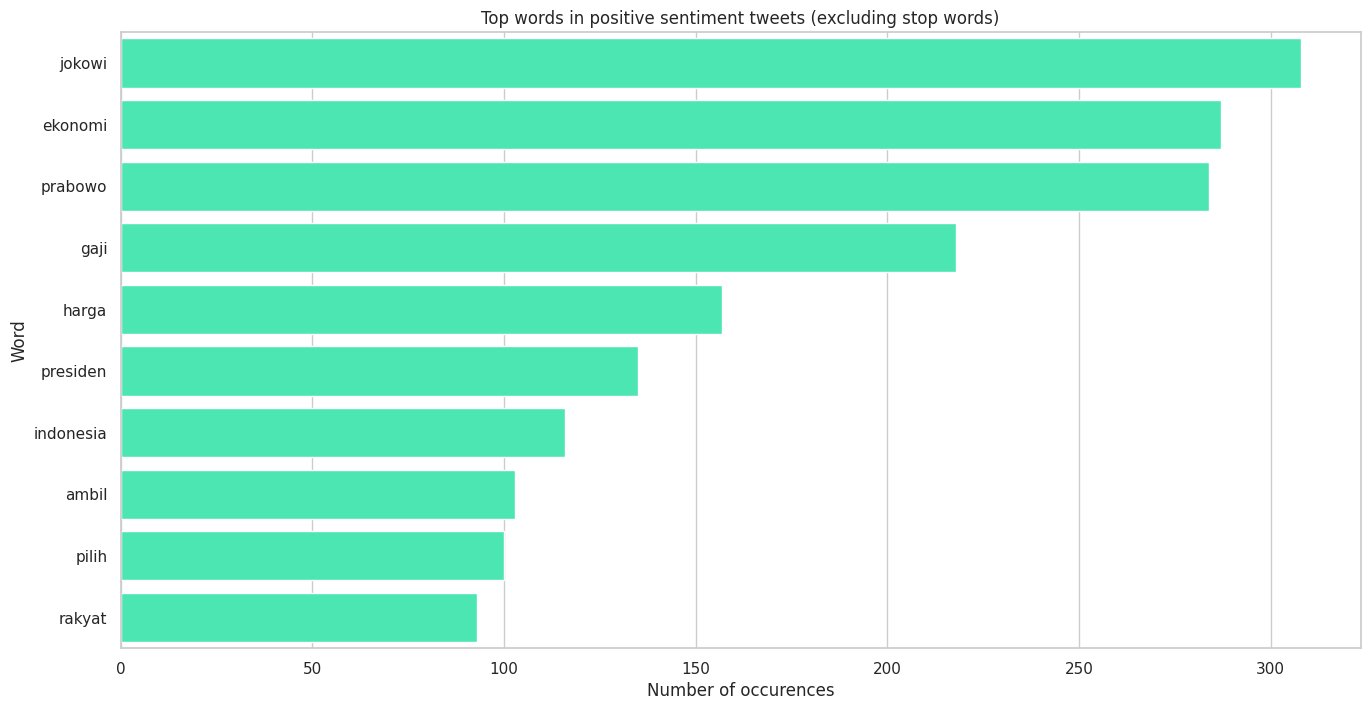

In [ ]:
# Top N words
top_n_words = count_top_n_words(tokenized_text_tweet, 10)  # get top 15 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words]
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#33FFBB');
ax.set_title('Top words in positive sentiment tweets (excluding stop words)');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('Word');
plt.show()

## 4.3. Hashtag

### 4.3.1. All  Sentiment

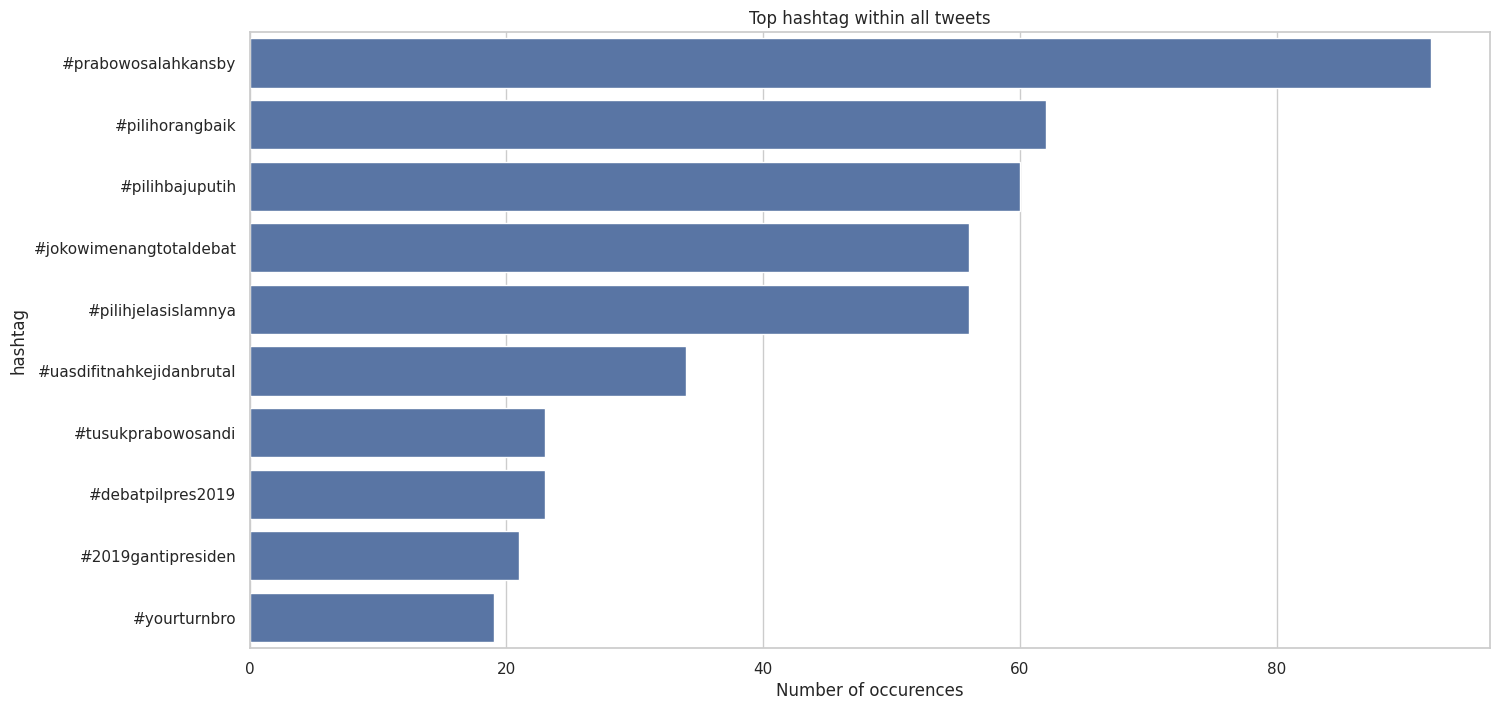

In [ ]:
all_hashtags = []
_ = tweets['hashtags'].apply(lambda dt: all_hashtags.extend(dt))


# Top N words
top_n_words = count_top_n_words(all_hashtags, 10)  # get top 10 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words]
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= 'b');
ax.set_title('Top hashtag within all tweets');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('hashtag');
plt.show()

### 4.3.2. Negative  Sentiment

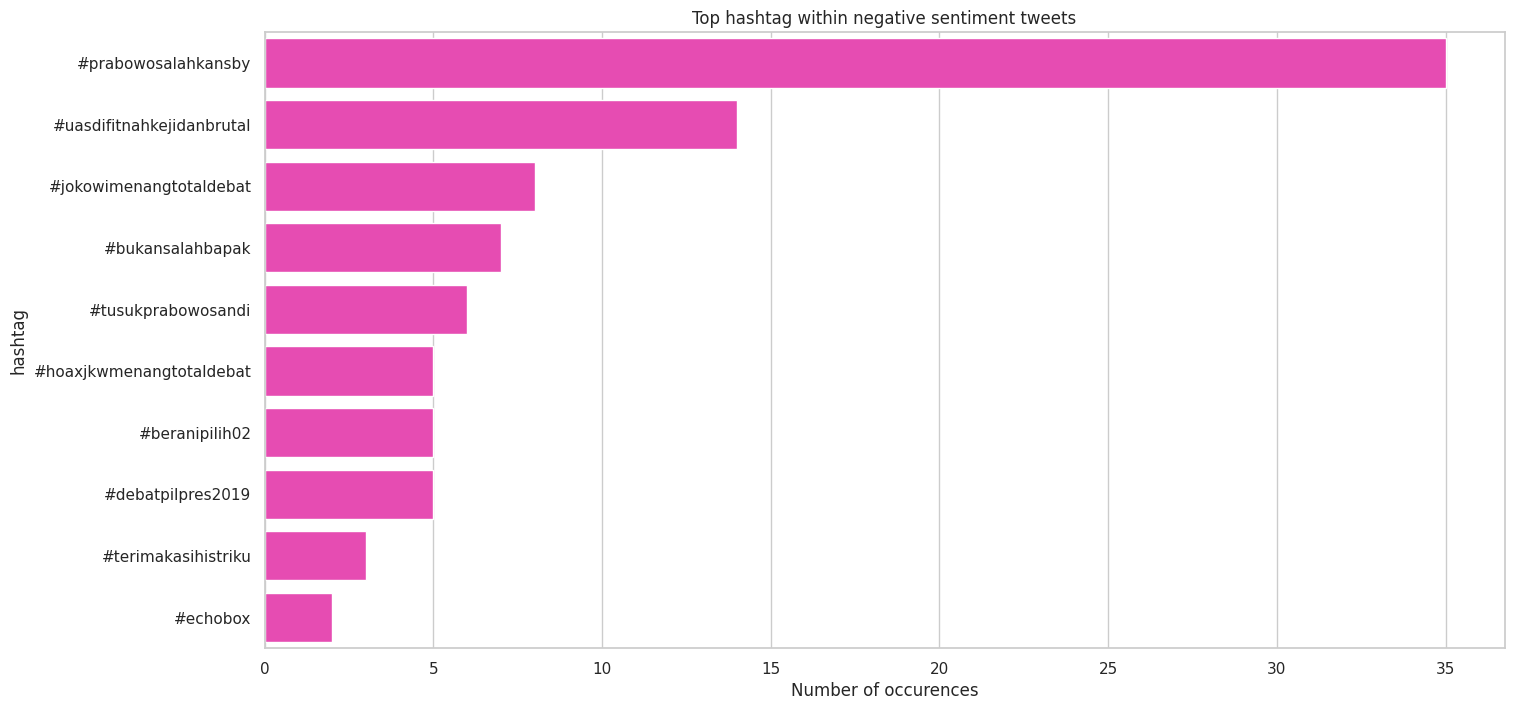

In [ ]:
all_hashtags = []
_ = tweets_negatif['hashtags'].apply(lambda dt: all_hashtags.extend(dt))


# Top N words
top_n_words = count_top_n_words(all_hashtags, 10)  # get top 10 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words]
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#FF33BB');
ax.set_title('Top hashtag within negative sentiment tweets');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('hashtag');
plt.show()

### 4.3.3. Netral  Sentiment

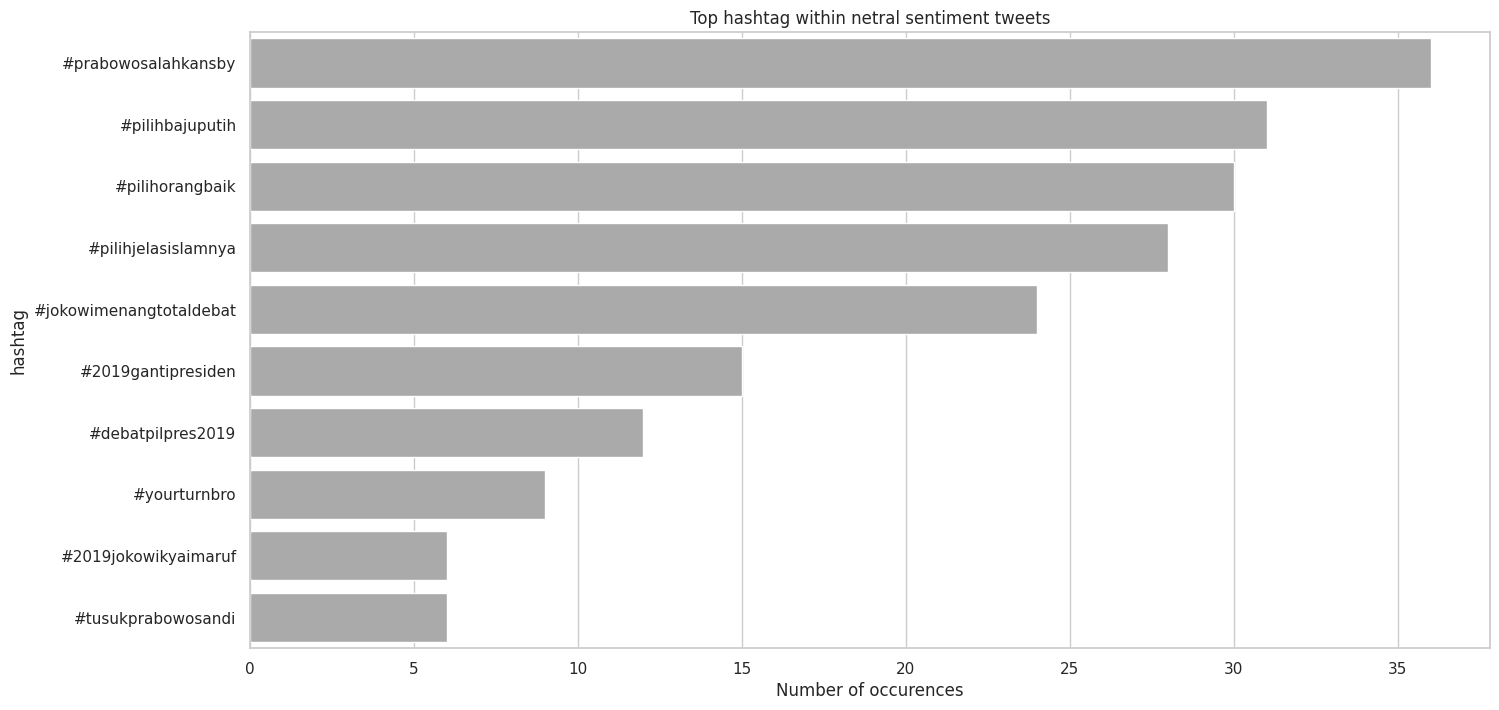

In [ ]:
all_hashtags = []
_ = tweets_netral['hashtags'].apply(lambda dt: all_hashtags.extend(dt))


# Top N words
top_n_words = count_top_n_words(all_hashtags, 10)  # get top 15 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words]
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#AAAAAA');
ax.set_title('Top hashtag within netral sentiment tweets');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('hashtag');
plt.show()

### 4.3.4. Positive  Sentiment

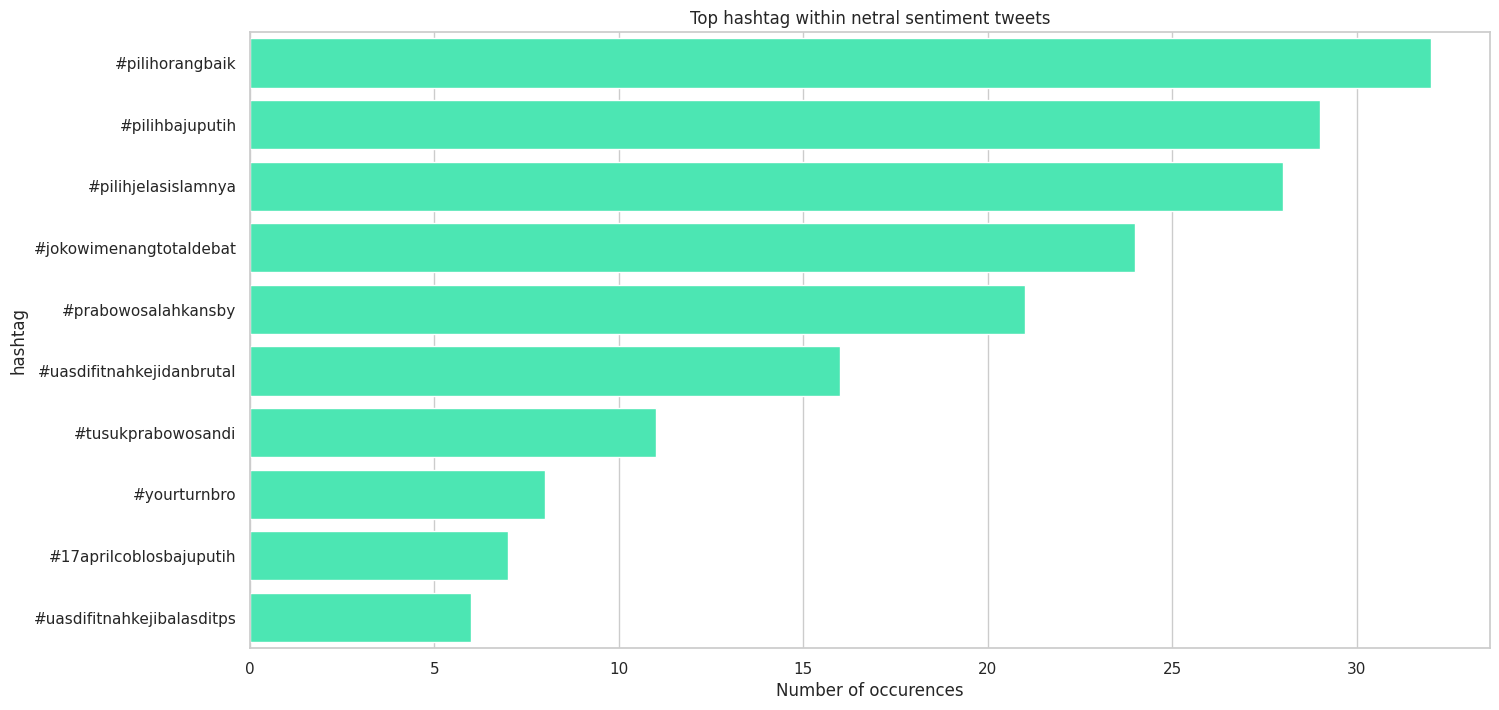

In [ ]:
all_hashtags = []
_ = tweets_positif['hashtags'].apply(lambda dt: all_hashtags.extend(dt))


# Top N words
top_n_words = count_top_n_words(all_hashtags, 10)  # get top 15 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words]
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#33FFBB');
ax.set_title('Top hashtag within netral sentiment tweets');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('hashtag');
plt.show()

#LSTM Step Work

In [ ]:
!pip install keras
!pip install pad_sequences

In [ ]:
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

In [ ]:
tweets.head()

,sentimen,tweet,num_words,cleaned_tweet,hashtags,clean_num_words
0,negatif,"Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â â€¦",19,prabowo indonesia harga bangsa asing berita hoax kuasa kan rockerung,[],10
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy? http://dlvr.it/R2pvZVÂ",11,batu langka tasbih jokowi haah habib luthfi harga mercy,[],9
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat pic.twitter.com/W2ythnxsTp",11,era jokowi ekonomi indonesia baik jokowilagi jokowimenangtotaldebat,"[#01indonesiamaju, #jokowilagi, #jokowimenangtotaldebat]",7
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!",17,sumatera selatan asi games dampak ekonomi langsung preksi capai triliun indonesia maju jokowi hebat,[],14
4,negatif,"Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh karena negara ngutang, setiap negara itu pasti ngutang, utang bisa dibayar kalo negara dapet penghasilan. Penghasilan negara itu ya dari pajak",34,negara ngutang bngun infrastruktur pake masyarakat masyarakat ngeluh negara ngutang negara ngutang utang bayar negara hasil hasil negara dari pajak,[],20


#Training Model Data

In [ ]:
grouped_data = tweets.groupby('sentimen') #mengelompokkan data berdasarkan sentimen

positive_data = grouped_data.get_group('positif')
negative_data = grouped_data.get_group('negatif')
netral_data = grouped_data.get_group('netral')

diubah ke float agar gak error saat LSTM

In [ ]:
from sklearn.preprocessing import OneHotEncoder
labels = netral_data['sentimen']
label_encoder = OneHotEncoder(sparse=False)
numeric_labels = label_encoder.fit_transform(np.array(labels).reshape(-1, 1))
netral_data['sentimen'] = numeric_labels

In [ ]:
print('Data Netral:')
netral_data

diubah ke float agar gak error saat LSTM

In [ ]:
from sklearn.preprocessing import OneHotEncoder
labels = positive_data['sentimen']
label_encoder = OneHotEncoder(sparse=False)
numeric_labels = label_encoder.fit_transform(np.array(labels).reshape(-1, 1))
positive_data['sentimen'] = numeric_labels

In [ ]:
print('Data Positif:')
positive_data

Data Positif:


,sentimen,tweet,num_words,cleaned_tweet,hashtags,clean_num_words
3,1.0,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!",17,sumatera selatan asi games dampak ekonomi langsung preksi capai triliun indonesia maju jokowi hebat,[],14
6,1.0,Masa tenang msih ngoceh aja..ttp jokowi harga mati...,8,tenang msih ngoceh ajattp jokowi harga mati,[],7
7,1.0,"#UASdifitnahKejiBalasDiTPS kerjasa ekonomi bilateral, multilateral kita doakan di TPS sambil dengarkan suara hati... #UASdifitnahKejiBalasDiTPS",14,uasfitnahkejibalastps kerjasa ekonomi bilateral multilateral doa tps dengar suara hati uasfitnahkejibalastps,"[#uasdifitnahkejibalasditps, #uasdifitnahkejibalasditps]",11
10,1.0,"#PilihOrangBaik #PilihJelasIslamnya #PilihBajuPutih Pilih pemimpin itu yg udh jelas banyak pencapaiannya. Nah, ini dia 5 pencapaian ekonomi selama pemerintahan Jokowi. Coblos 01 Yuk Kerja Pasti ! https://bit.ly/2OgymxtÂ",27,pilihorangbaik pilihjelasislamnya pilihbajuputih pilih pimpin jelas capai a capai ekonomi perintah jokowi coblos yuk kerja,"[#pilihorangbaik, #pilihjelasislamnya, #pilihbajuputih]",15
11,1.0,"Calon presiden Jokowi menjelaskan program Kartu Pra Kerja akan memberikan insentif dalam kurun waktu tertentu, bukan berarti memberikan gaji secara cuma-cuma bagi masyarakat yang belum berpenghasilan. #2019JokowiKyaiMaruf pic.twitter.com/Nj2hhmiIzv",28,calon presiden jokowi program kartu pra kerja insentif kurun tentu arti beri gaji cumacuma masyarakat hasil,[#2019jokowikyaimaruf],16
...,...,...,...,...,...,...
1757,1.0,"Bismillah, dilihat dari hasil debat malam ini pasangan Prabowo sandi sangat konsen dengan masyarakat, diutamakan swasembada pangan, harga bahan pokok,listrik, bbm turun, menciptakan 14 JT lapangan kerja.. Insya Allah mantap pilih 02 Yg setuju RT Broo.. #BeraniPilih02",37,lihat hasil debat malam pasang prabowo sangat konsen masyarakat utama swasembada pangan harga bahan pokoklistrik bbm turun cipta jt lapang kerja insya allah pilih tuju rt,[#beranipilih02],26
1760,1.0,Luar biasa performa dan penjelasan Pak Jokowi dan KH Ma'ruf Amin tentang capaian ekonomi dan pemerataan dari sabang sampai merauke #JokowiMenangTotalDebat #01IndonesiaMaju #01JokowiAmin,23,biasa performa jelas jokowi kh maruf amin capai ekonomi perata sabang merauke jokowimenangtotaldebat,"[#jokowimenangtotaldebat, #01indonesiamaju, #01jokowiamin]",13
1767,1.0,Wow ga ngambil gaji sedikitpun kalo jadi presiden. YaAllah semoga rejeki pak prabowo dan pak sandi dilimpahkan terus menerus. Aamiin.,20,ga ngambil gaji kit ja presiden yaallah rejeki prabowo pak limpah terus aamiin,[],13
1795,1.0,"Tidak hanya utk keamanan negeri ini, kemajuan ekonomi, infrastruktur, pendidikan, birokrasi,maritim dan lainnya. Berhasil mengarah kearah lbh baik. Lanjut y Pak @jokowi 2 periode #PrabowoJAHAP #02TunggangiIslam #PrabowoSakit pic.twitter.com/WJBtINHYKl",28,hanya aman negeri maju ekonomi infrastruktur pen birokrasimaritim lain hasil arah arah lbh lanjut pak jokowi periode prabowojahap prabowosakit pictwittercomwjbtinhykl,"[#prabowojahap, #02tunggangiislam, #prabowosakit]",20


diubah ke float agar gak error saat LSTM

In [ ]:
from sklearn.preprocessing import OneHotEncoder
labels = negative_data['sentimen']
label_encoder = OneHotEncoder(sparse=False)
numeric_labels = label_encoder.fit_transform(np.array(labels).reshape(-1, 1))
negative_data['sentimen'] = numeric_labels

In [ ]:
print('Data Negatif:')
negative_data

##7.1 Training Positive Sentiment

Split dataset positive

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils.data_utils import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [ ]:
X_positive = positive_data.tweet
Y_positive = positive_data.sentimen
label_encoder = LabelEncoder()
Y_pos = label_encoder.fit_transform(Y_positive)
Y_pos = Y_positive.reshape(-1,1)

Tokenisasi

In [ ]:
# conversi teks ke sequence
max_words = 1000
max_len = 100
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_positive)
sequences = tok.texts_to_sequences(X_positive)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

Pembentukan model LSTM

In [ ]:
# define RNN
def RNN():
    inputs = Input(name='inputs', shape=[max_length])
    layer = Embedding(max_words, 100, input_length=max_length)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [ ]:
model_positive = RNN()
model_positive.summary()
model_positive.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Training Model

In [ ]:
model_positive.fit(sequences_matrix, Y_positive,batch_size=128, epochs=10,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])

In [ ]:
test_sequences = tok.texts_to_sequences(X_positive)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)

In [ ]:
accr = model_positive.evaluate(test_sequences_matrix, Y_test)

In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

##7.2 Training Negative Sentiment

Split dataset negative

In [ ]:
X = negative_data.tweet
Y = negative_data.sentimen
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
Y = Y.reshape(-1,1)

Tokenisasi

In [ ]:
# conversi teks ke sequence
max_words = 1000
max_len = 100
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

Pembentukan model LSTM

In [ ]:
model_negative = RNN()
model_negative.summary()
model_negative.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Training Model

In [ ]:
model_negative.fit(sequences_matrix, Y_train,batch_size=128, epochs=10,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])

In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)

In [ ]:
accr = model_negative.evaluate(test_sequences_matrix, Y_test)

In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

##7.1 Training Netral Sentiment

Split dataset netral

In [ ]:
X = netral_data.tweet
Y = netral_data.sentimen
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
Y = Y.reshape(-1,1)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

Tokenisasi

In [ ]:
# conversi teks ke sequence
max_words = 1000
max_len = 100
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

Pembentukan model LSTM

In [ ]:
model_netral = RNN()
model_netral.summary()
model_netral.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Training Model

In [ ]:
model_netral.fit(sequences_matrix, Y_train,batch_size=128, epochs=10,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])

In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)

In [ ]:
accr = model_netral.evaluate(test_sequences_matrix, Y_test)

In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Training all model

In [ ]:
from keras.layers import Concatenate

In [ ]:
X = tweets.tweet
Y = tweets.sentimen
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
Y = Y.reshape(-1,1)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [ ]:
# conversi teks ke sequence
max_words = 1000
max_len = 100
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [ ]:
inputs = Input(name='inputs', shape=[100])
layer = Embedding(1000, 50, input_length=100)(inputs)
layer = LSTM(64)(layer)
layer = Dense(256,name='FC1')(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(3,name='combine')(layer)
layer = Activation('softmax')(layer)
model = Concatenate([model_netral,model_positive,model_negative])
model = Model(inputs=inputs, outputs=layer)

In [ ]:
from keras.losses import *

In [ ]:
model.summary()
model.compile(loss=SparseCategoricalCrossentropy(), optimizer=RMSprop(), metrics=['accuracy'])

In [ ]:
model.fit(sequences_matrix, Y_train,batch_size=128, epochs=5,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])

In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix, Y_test)

In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

## 8.2 Testing Output